# Model - VGG16

## Importing Packages

In [1]:
# Packages

import keras,os # keras is used to include deep learning layers
from keras.models import Sequential # any deep learning model is built begining with sequential model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten # these layers are imprted from keras layers
from keras.preprocessing.image import ImageDataGenerator # to load images from image generator
import numpy as np # to handle numpy arrays
import matplotlib.pyplot as plt # matplotlib is used to plot
import cv2 # opencv is used to read and handle images
from keras.preprocessing.image import load_img # used to load images from path
from keras.preprocessing.image import img_to_array # used to convert images to arrays
from keras.applications.vgg16 import preprocess_input # for any given input the values are processed as per vgg16 application
from keras.applications.vgg16 import decode_predictions # from the predictions of vgg16 they are classified
from keras.applications.vgg16 import VGG16 # this is used to access pre-trained VGG16 application from keras
from pathlib import Path #used to handle paths
import tensorflow as tf # tensorflow is used to build neural nets
import pandas as pd # pandas is used to handle dataframes
from progressbar import ProgressBar # progress bar helps us in showing us time taken for a task
import warnings # any warnings displayed 
import tensorflow.keras as keras
warnings.filterwarnings('ignore')
progress = ProgressBar() 

# This definition is used to read images from the path and store them into a numpy array

def load_images_from_folder(folder):
    images = []
    for filename in progress(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (256, 256)) 
        if img is not None:
            images.append(img)
            
    img = np.array(images)
    # we are deleting unnecessary memory as its huge
    del images
    return img

## Data Loading

In [2]:
# calling the definition to store numpy array of images from the path
crop = load_images_from_folder('data\image\cropped')

100% (18448 of 18448) |##################| Elapsed Time: 0:01:57 Time:  0:01:57


In [3]:
# this dataframe is used to help us with labels of each image
df_clean = pd.read_csv("Covid_EDA_cropped.csv")
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18448 entries, 0 to 18447
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   File_no       18448 non-null  int64 
 1   Source        18448 non-null  object
 2   Catogery      18448 non-null  object
 3   Processed     18448 non-null  object
 4   Probe_Type    18448 non-null  object
 5   Frame_number  18448 non-null  object
dtypes: int64(1), object(5)
memory usage: 864.9+ KB


,File_no,Source,Catogery,Processed,Probe_Type,Frame_number
0,100,litfl,other,prc,convex,frame0
1,100,litfl,other,prc,convex,frame1
2,100,litfl,other,prc,convex,frame10
3,100,litfl,other,prc,convex,frame11
4,100,litfl,other,prc,convex,frame12


## Converting Categorical Labels to Ordinal Labels

In [4]:
# As labels are categorical data we are converting them to ordinal for ease of modelling and handling loss function
labs = []
for i in df_clean['Catogery']:
    if i == 'covid':
        labs.append(0)
    if i == 'normal':
        labs.append(1)
        
    if i =='other':
        labs.append(2)
    if i =='pneumonia':
        labs.append(3)

## Data Normalization

In [5]:
# data normalization is used to get the RGB filters from scale 0-255 to 0-1, so that it is independent of scale and everything 
# is in unity
crop = crop.astype('float32') / 255
labs = np.array(labs)


## Splitting Data to train and test sets

In [6]:
# train test split package helps us in dividing the data into train and test sets

from sklearn.model_selection import train_test_split

# we are specifically using startify method as we have different proportions of data labels

image_train, image_test, label_train, label_test = train_test_split(crop,labs,random_state=1, stratify=labs)

## Distribution of Data

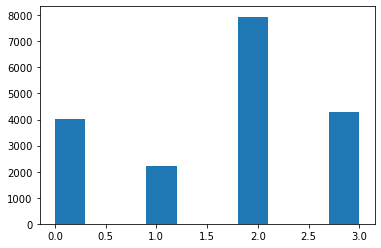

In [7]:
plt.hist(labs)
plt.show()

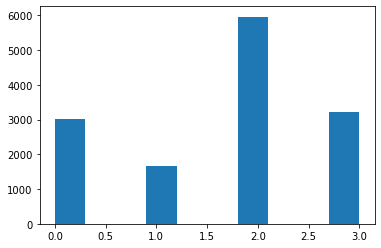

In [8]:
plt.hist(label_train)
plt.show()

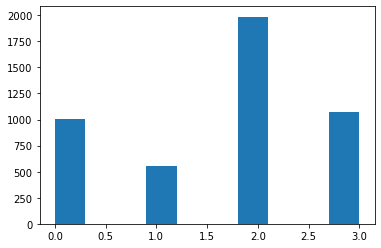

In [9]:
plt.hist(label_test)
plt.show()

#### Explanation:We have splitted the trainig data with 80% of images and testing data with 20% of images.

#### Data Stratification maintains the same sample of data for all four category in both training and testing data.  - After splitting the data all class labels are similarly distributed:

- Covid is indicated by “0”
- Normal is indicated by “1”
- Other is indicated by “2”
- Pneumonia is indicated by “3”

In [10]:
# veryfying the final shapes of the data
print(image_train.shape)
print(len(label_train))
# removing unnecessary data to conserve memory
del crop

(13836, 256, 256, 3)
13836


In [11]:
# veryfying the final shapes of the data
print(image_test[0].shape)
print(len(label_test))

(256, 256, 3)
4612


## Model Training

In [12]:
#Vgg16 model Training
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False ,input_shape = (256,256,3)) # defining the VGG model with image parameters
base_model.trainable = False ## Not trainable weights
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, ZeroPadding2D # importing layers

flatten_layer = layers.Flatten() # defining flatten layer
dense_layer_1 = layers.Dense(32, activation='relu') # one dense layer with 32 neurons
dense_layer_2 = layers.Dense(20, activation='relu') # another dense layer with 20 neurons
prediction_layer = layers.Dense(4, activation='softmax') # 4 neurns for each class label and activation function of Softmax


model_vgg = Sequential([ #defining a sequential model 
    base_model, # loading the base model
    flatten_layer, # ten followed by a flatten layer
    dense_layer_1, # then the first layer
    dense_layer_2, # then the nxt layer 
    prediction_layer # the prediction or the output layer
])

# loading the data before compiling. So that, if the model is trained with new images the weights are updated respectively.
model_vgg.load_weights('modelvgg_weights.h5')
model_vgg.compile(
    optimizer='adam', # adam optimizer is the best optimizer
    loss='sparse_categorical_crossentropy', # as we have ordinal data, sparese categorical crossentropy works the best
    metrics=['accuracy'],
)


# after repeated trial and errors training with 2000 images is the maximum capacity to reach without internal error
# so for each training phase we use 2000 images at once with batch size of 5 and 5 epochs

#hist = model_vgg.fit(image_train[:2000],label_train[:2000], epochs=5, verbose=1, batch_size=10)





In [9]:
hist = model_vgg.fit(image_train[2001:4000],label_train[2001:4000], epochs=5, verbose=1, batch_size=10)

Epoch 1/5
200/200 [==============================] - 135s 671ms/step - loss: 0.1431 - accuracy: 0.9510
Epoch 2/5
200/200 [==============================] - 131s 656ms/step - loss: 0.1697 - accuracy: 0.9369
Epoch 3/5
200/200 [==============================] - 131s 655ms/step - loss: 0.0536 - accuracy: 0.9820
Epoch 4/5
200/200 [==============================] - 131s 653ms/step - loss: 0.0478 - accuracy: 0.9780
Epoch 5/5
200/200 [==============================] - 131s 657ms/step - loss: 0.0557 - accuracy: 0.9780


In [62]:
# saving model for each best case

model_vgg.save_weights('modelvgg_weights.h5')
#model_vgg.load_weights('modelvgg_weights.h5')

In [27]:
hist = model_vgg.fit(image_train[4001:6000],label_train[4001:6000], epochs=5, verbose=1, batch_size=10)

Epoch 1/5
200/200 [==============================] - 118s 590ms/step - loss: 0.1064 - accuracy: 0.9620
Epoch 2/5
200/200 [==============================] - 118s 591ms/step - loss: 0.0381 - accuracy: 0.9790
Epoch 3/5
200/200 [==============================] - 118s 592ms/step - loss: 0.0334 - accuracy: 0.9820
Epoch 4/5
200/200 [==============================] - 120s 600ms/step - loss: 0.0342 - accuracy: 0.9800
Epoch 5/5
200/200 [==============================] - 122s 609ms/step - loss: 0.0274 - accuracy: 0.9850


In [29]:
hist = model_vgg.fit(image_train[6001:8000],label_train[6001:8000], epochs=5, verbose=1, batch_size=10)

Epoch 1/5
200/200 [==============================] - 117s 585ms/step - loss: 0.0403 - accuracy: 0.9790
Epoch 2/5
200/200 [==============================] - 118s 590ms/step - loss: 0.0313 - accuracy: 0.9800
Epoch 3/5
200/200 [==============================] - 118s 592ms/step - loss: 0.0301 - accuracy: 0.9780
Epoch 4/5
200/200 [==============================] - 119s 594ms/step - loss: 0.0308 - accuracy: 0.9780
Epoch 5/5
200/200 [==============================] - 119s 593ms/step - loss: 0.2006 - accuracy: 0.9179


In [31]:
hist = model_vgg.fit(image_train[8001:10500],label_train[8001:10500], epochs=5, verbose=1, batch_size=10)

Epoch 1/5
200/200 [==============================] - 116s 582ms/step - loss: 0.0678 - accuracy: 0.9660
Epoch 2/5
200/200 [==============================] - 116s 581ms/step - loss: 0.0386 - accuracy: 0.9720
Epoch 3/5
200/200 [==============================] - 116s 580ms/step - loss: 0.0643 - accuracy: 0.9650
Epoch 4/5
200/200 [==============================] - 116s 581ms/step - loss: 0.0661 - accuracy: 0.9750
Epoch 5/5
200/200 [==============================] - 116s 582ms/step - loss: 0.0328 - accuracy: 0.9800


In [33]:
hist = model_vgg.fit(image_train[10501:12000],label_train[10501:12000], epochs=5, verbose=1, batch_size=7)

Epoch 1/5
200/200 [==============================] - 116s 582ms/step - loss: 0.0352 - accuracy: 0.9760
Epoch 2/5
200/200 [==============================] - 116s 582ms/step - loss: 0.0338 - accuracy: 0.9740
Epoch 3/5
200/200 [==============================] - 116s 581ms/step - loss: 0.0328 - accuracy: 0.9790
Epoch 4/5
200/200 [==============================] - 116s 580ms/step - loss: 0.0327 - accuracy: 0.9740
Epoch 5/5
200/200 [==============================] - 116s 581ms/step - loss: 0.0323 - accuracy: 0.9820


In [61]:
hist = model_vgg.fit(image_train[12001:],label_train[12001:], epochs=5, verbose=1, batch_size=5)

Epoch 1/5
200/200 [==============================] - 22s 111ms/step - loss: 0.0339 - accuracy: 0.9770
Epoch 2/5
200/200 [==============================] - 22s 111ms/step - loss: 0.0258 - accuracy: 0.9810
Epoch 3/5
200/200 [==============================] - 22s 111ms/step - loss: 0.0267 - accuracy: 0.9760
Epoch 4/5
200/200 [==============================] - 22s 111ms/step - loss: 0.0259 - accuracy: 0.9810
Epoch 5/5
200/200 [==============================] - 22s 112ms/step - loss: 0.0251 - accuracy: 0.9840


In [17]:
ta = []
s=0
for i in range(10,13000,10):
    row=model_vgg.predict(image_train[s:i])
    s+=10
    ta.append(row)

In [18]:
tan = np.asarray(ta)
tan.shape

(1299, 10, 4)

In [19]:

tan=tan.reshape(12990,4)

In [20]:
y_pred = []
for i in tan:
    m = np.argmax(i)
    y_pred.append(m)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(label_train[:12990], y_pred, target_names=["Covid","Normal","Other","pneumonia"]))

              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00      2819
      Normal       1.00      1.00      1.00      1557
       Other       1.00      0.95      0.97      5589
   pneumonia       0.92      1.00      0.96      3025

    accuracy                           0.98     12990
   macro avg       0.98      0.99      0.98     12990
weighted avg       0.98      0.98      0.98     12990



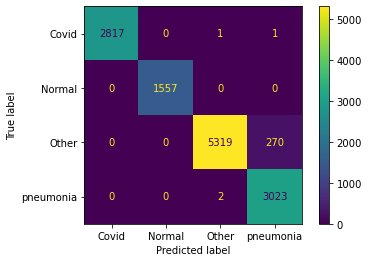

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(label_train[:12990], y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal","Other","pneumonia"])
disp.plot()

plt.show()

##  Results

### Final Train accuracy is 98.40%

In [17]:
# While we have tried to compute all the test labels, resource exhaustion error is occured : i.e. gpu is unable to allocate
# enough and this processs is not done using cpu

# So, we have created a process where memory is allocated in batches of 10 so memory doesnt break 

ta = []
s=0
for i in range(10,4610,10):
    row=model_vgg.predict(image_test[s:i])
    s+=10
    ta.append(row)

In [24]:

tan = np.asarray(ta)
tan.shape
tan=tan.reshape(4600,4)

(460, 10, 4)

In [31]:
# the predicitons are probabilities of each class so, we have used argmax of each probabilty to conclude the final class
y_pred = []
for i in tan:
    m = np.argmax(i)
    y_pred.append(m)

In [33]:
# classifictaion report is used to understand the performance of model clearly for each class label

from sklearn.metrics import classification_report
print(classification_report(label_test[:4600], y_pred, target_names=["Covid","Normal","Other","pneumonia"]))

              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       998
      Normal       1.00      1.00      1.00       548
       Other       1.00      0.95      0.98      1980
   pneumonia       0.92      1.00      0.96      1074

    accuracy                           0.98      4600
   macro avg       0.98      0.99      0.98      4600
weighted avg       0.98      0.98      0.98      4600



### Final test accuracy is 98%

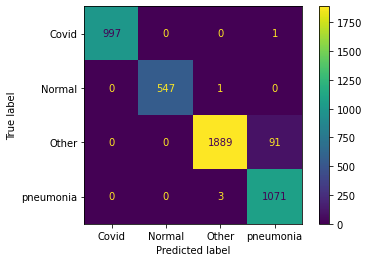

In [36]:
# confusion matrix helps us understand the false probabilities 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(label_test[:4600], y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal","Other","pneumonia"])
disp.plot()

plt.show()